# Project: Wrangling and Analyze Data

In [1]:
# To store and hide (gitignore) Twitter App credentials
from env import *

# setting the random seed for reproducibility
import random
random.seed(493)

# for manipulating dataframes
import pandas as pd
import numpy as np

# for handling twitter and web requests
import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer
import requests
import io

# natural language processing
import re
import unicodedata
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords

# for natural language processing
import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm
nlp = en_core_web_sm.load()

# for working with timestamps
from datetime import datetime
from dateutil.parser import parse

# for visualizations
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
# import plotly.express as px # use for interactivity
sns.set(style="whitegrid")

# to print out all the outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dd\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Dd\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Dd\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
def show_missing(df):
    """
    Takes a dataframe and returns a dataframe with stats
    on missing and null values with their percentages.
    """
    null_count = df.isnull().sum()
    null_percentage = (null_count / df.shape[0]) * 100
    empty_count = pd.Series(((df == ' ') | (df == '')).sum())
    empty_percentage = (empty_count / df.shape[0]) * 100
    nan_count = pd.Series(((df == 'nan') | (df == 'NaN')).sum())
    nan_percentage = (nan_count / df.shape[0]) * 100
    dfx = pd.DataFrame({'num_missing': null_count, 'missing_percentage': null_percentage,
                         'num_empty': empty_count, 'empty_percentage': empty_percentage,
                         'nan_count': nan_count, 'nan_percentage': nan_percentage})
    return dfx

In [3]:
def get_values(df, columns):
    """
    Take a dataframe and a list of columns and
    returns the value counts for the columns.
    """
    for column in columns:
        print(column)
        print('=====================================')
        print(df[column].value_counts(dropna=False))
        print('\n')

def show_values(df, param):
    if param == 'all':
        get_values(df, df.columns)
    else:
        get_values(df, param) 

In [4]:
def convert_datatype(dfx, column, totype):
    """
    This function converts a column's datatype
    from one to the specified datatype
    and returns the modified dataframe.
    """
    dfx[column] = dfx[column].astype(totype)
    return dfx

In [5]:
# ==========================================================
# Dd's Notes:
# Almost all of the code here came from my Github repo that
# can be found on the Github link in the Resources section.
# ==========================================================

ADDITIONAL_STOPWORDS = ['ignore', 'me']

def clean(sentence):
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
    sentence = (unicodedata.normalize('NFKD', sentence)
        .encode('ascii', 'ignore')
        .decode('utf-8', 'ignore')
        .lower())
    words = re.sub(r'[^\w\s]', '', sentence).split()
    word_list = [wnl.lemmatize(word) for word in words if word not in stopwords]
    return word_list

def get_words(df, column):
    """
    Takes a dataframe and a column and returns a list of
    cleaned words that is returned by clean().

            Parameters:
                    df (dataframe): A pandas dataframe
                    column (series): A pandas series

            Returns:
                    word_list (list): A list of cleaned words
    """
    return clean(''.join(str(df[column].tolist())))

def get_unigrams(words):
    """
    Takes in a list of words and returns a series of
    unigrams with value counts.
    """
    return  pd.Series(words).value_counts()

def get_bigrams(words):
    """
    Takes in a list of words and returns a series of
    bigrams with value counts.
    """
    return (pd.Series(nltk.ngrams(words, 2)).value_counts())[:20]

def get_trigrams(words):
    """
    Takes in a list of words and returns a series of
    trigrams with value counts.
    """
    return (pd.Series(nltk.ngrams(words, 3)).value_counts())[:20]

def get_qualgrams(words):
    """
    Takes in a list of words and returns a series of
    qualgrams with value counts.
    """
    return (pd.Series(nltk.ngrams(words, 4)).value_counts())[:20]

def get_ngrams(df,column):
    """
    Takes in a dataframe with column name and generates a
    dataframe of unigrams, bigrams, trigrams, and qualgrams.
    """
    return get_bigrams(get_words(df,column)).to_frame().reset_index().rename(columns={'index':'bigram','0':'count'}), \
           get_trigrams(get_words(df,column)).to_frame().reset_index().rename(columns={'index':'trigram','0':'count'}), \
           get_qualgrams(get_words(df,column)).to_frame().reset_index().rename(columns={'index':'qualgram','0':'count'})

def viz_bigrams(df, column, title):
    """
    Takes in a dataframe, target column name, and specified title
    for the bar chart visualization of bigrams.
    """
    get_bigrams(get_words(df,column)).sort_values().plot.barh(color='blue', width=.9, figsize=(12, 8))

    plt.title(title)
    plt.ylabel('Bigram')
    plt.xlabel('# Occurances')

def viz_trigrams(df, column, title):
    """
    Takes in a dataframe, target column name, and specified title
    for the bar chart visualization of trigrams.
    """
    get_trigrams(get_words(df,column)).sort_values().plot.barh(color='blue', width=.9, figsize=(12, 8))

    plt.title(title)
    plt.ylabel('Trigram')
    plt.xlabel('# Occurances')
    
def viz_qualgrams(df, column, title):
    """
    Takes in a dataframe, target column name, and specified title
    for the bar chart visualization of qualgrams.
    """
    get_bigrams(get_words(df,column)).sort_values().plot.barh(color='blue', width=.9, figsize=(12, 8))

    plt.title(title)
    plt.ylabel('Qualgram')
    plt.xlabel('# Occurances')                                                                        

## Data Gathering
In the cell below, gather **all** three pieces of data for this project and load them in the notebook. **Note:** the methods required to gather each data are different.
1. Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

In [6]:
# Read a csv file locally
twitter_enhanced_df = pd.read_csv('../data/in/twitter-archive-enhanced.csv')

2. Use the Requests library to download the tweet image prediction (image_predictions.tsv)

In [7]:
# Direct download from source
r = requests.get('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv')
r.status_code
r.headers['content-type']
r.encoding

200

'text/tab-separated-values; charset=utf-8'

'utf-8'

In [8]:
# Convert tsv to dataframe
image_predictions_df = pd.read_csv(io.StringIO(r.text), sep='\t')

3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

In [9]:
# ==========================================================
# Dd's Notes:
# Commented out because it takes a long tinme to run.
# ==========================================================

# # Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# # These are hidden to comply with Twitter's API terms and conditions
# consumer_key = CONSUMER_KEY
# consumer_secret = CONSUMER_SECRET
# access_token = ACCESS_TOKEN
# access_token_secret = ACCESS_SECRET

# auth = tweepy.OAuth1UserHandler(
#    consumer_key, consumer_secret, access_token, access_token_secret
# )

# api = tweepy.API(auth, wait_on_rate_limit=True)

In [10]:
# tweet_ids = twitter_enhanced_df.tweet_id.values
# len(tweet_ids)

In [11]:
# sample_tweet_ids = tweet_ids[0:100].tolist()
# len(sample_tweet_ids)
# type(sample_tweet_ids)
# sample_tweet_ids

In [12]:
# # creating a list for tweets with exceptions/errors 
# error_list = []

# # List of tweets
# tweets_list = []

# # Iterate and add each tweet json to tweets_list
# for tweet_id in tweet_ids:
#     try:
#         tweet = api.get_status(tweet_id, tweet_mode= 'extended')._json        
#         favorites = tweet['favorite_count'] # number of favorites for the tweet
#         retweets = tweet['retweet_count'] # number of retweets
#         followers = tweet['user']['followers_count'] # number of followers of the user who tweeted
#         favourites = tweet['user']['favourites_count'] # number of favourites for the user who tweeted
#         timestamp = tweet['created_at'] # the timestamp of creation of the tweet
#         tweets_list.append({'tweet_id': int(tweet_id),
#                         'favorites': int(favorites),
#                         'retweets': int(retweets),
#                         'followers': int(followers),
#                         'favourites': int(favourites),
#                         'timestamp': pd.to_datetime(timestamp)})
#     except Exception as e:
#         print(str(tweet_id)+ " _ " + str(e))
#         error_list.append(tweet_id)

In [13]:
# # total tweets received from api
# print("Number of successes: ", len(tweets_list))

# # Number of the errors received from api
# print("Number of the errors: ", len(error_list))

In [14]:
# tweets_json_df = pd.DataFrame(tweets_list, columns = ['tweet_id',
#                                                       'favorites',
#                                                       'retweets',
#                                                       'followers',
#                                                       'favourites',
#                                                       'timestamp'])
# # saving the dataFrame to file
# tweets_json_df.to_csv('../data/in/tweet-json.txt', encoding = 'utf-8', index=False)

In [15]:
# Read the saved tweet-json.txt file into a dataframe
tweets_json_df = pd.read_csv('../data/in/tweet-json.txt', encoding = 'utf-8')

># Dataframes:
>1. twitter_enhanced_df
>1. image_predictions_df
>1. tweets_json_df

## Assessing Data
In this section, detect and document at least **eight (8) quality issues and two (2) tidiness issue**. You must use **both** visual assessment
programmatic assessement to assess the data.

**Note:** pay attention to the following key points when you access the data.

* You only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.
* Assessing and cleaning the entire dataset completely would require a lot of time, and is not necessary to practice and demonstrate your skills in data wrangling. Therefore, the requirements of this project are only to assess and clean at least 8 quality issues and at least 2 tidiness issues in this dataset.
* The fact that the rating numerators are greater than the denominators does not need to be cleaned. This [unique rating system](http://knowyourmeme.com/memes/theyre-good-dogs-brent) is a big part of the popularity of WeRateDogs.
* You do not need to gather the tweets beyond August 1st, 2017. You can, but note that you won't be able to gather the image predictions for these tweets since you don't have access to the algorithm used.



In [16]:
# Show missing values, empties, and NaNs
show_missing(twitter_enhanced_df)

,num_missing,missing_percentage,num_empty,empty_percentage,nan_count,nan_percentage
tweet_id,0,0.000000,0,0.0,0,0.0
in_reply_to_status_id,2278,96.689304,0,0.0,0,0.0
in_reply_to_user_id,2278,96.689304,0,0.0,0,0.0
timestamp,0,0.000000,0,0.0,0,0.0
source,0,0.000000,0,0.0,0,0.0
text,0,0.000000,0,0.0,0,0.0
retweeted_status_id,2175,92.317487,0,0.0,0,0.0
retweeted_status_user_id,2175,92.317487,0,0.0,0,0.0
retweeted_status_timestamp,2175,92.317487,0,0.0,0,0.0
expanded_urls,59,2.504244,0,0.0,0,0.0


In [17]:
# Check data types
twitter_enhanced_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

>The following columns needs to be of data type string or object
> - "tweet_id"
> - "in_reply_to_status_id"
> - "in_reply_to_user_id
> - "retweeted_status_id"
> - "retweeted_status_user_id"

>The following columns needs to be of data type instead of string or object
> - "timestamp"
> - "retweeted_status_timestamp"

In [18]:
# Take a peek
twitter_enhanced_df.sample(100)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1629,684567543613382656,NaN,NaN,2016-01-06 02:49:55 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Bobby. He doesn't give a damn about personal space. Convinced he called shotgun first. 4/10 not the best dog https://t.co/b8XW69gSaU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/684567543613382656/photo/1,4,10,Bobby,None,None,None,None
492,813217897535406080,NaN,NaN,2016-12-26 03:00:30 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here is Atlas. He went all out this year. 13/10 downright magical af https://t.co/DVYIZOnO81,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/813217897535406080/photo/1,https://twitter.com/dog_rates/status/813217897535406080/photo/1,https://twitter.com/dog_rates/status/813217897535406080/photo/1,https://twitter.com/dog_rates/status/813217897535406080/photo/1",13,10,Atlas,None,None,None,None
892,759447681597108224,NaN,NaN,2016-07-30 17:56:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Oakley. He has no idea what happened here. Even offered to help clean it up. 11/10 such a heckin good boy https://t.co/vT3JM8b989,NaN,NaN,NaN,https://twitter.com/dog_rates/status/759447681597108224/photo/1,11,10,Oakley,None,None,None,None
2157,669583744538451968,NaN,NaN,2015-11-25 18:29:39 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Special dog here. Pretty big. Neck kinda long for dog. Cool spots. Must be a Dalmatian variant. 6/10 would still pet https://t.co/f8GXeDbFzu,NaN,NaN,NaN,https://twitter.com/dog_rates/status/669583744538451968/photo/1,6,10,None,None,None,None,None
1575,687476254459715584,NaN,NaN,2016-01-14 03:28:06 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Curtis. He's a fluffball. 11/10 would snug this pupper https://t.co/1DzInODwrj,NaN,NaN,NaN,https://twitter.com/dog_rates/status/687476254459715584/photo/1,11,10,Curtis,None,None,pupper,None
1628,684588130326986752,NaN,NaN,2016-01-06 04:11:43 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine - Make a Scene</a>",This pupper just got his first kiss. 12/10 he's so happy https://t.co/2sHwD7HztL,NaN,NaN,NaN,https://vine.co/v/ihWIxntjtO7,12,10,None,None,None,pupper,None
512,811744202451197953,NaN,NaN,2016-12-22 01:24:33 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Halo. She likes watermelon. 13/10 https://t.co/TZkiQZqwA6,NaN,NaN,NaN,https://twitter.com/dog_rates/status/811744202451197953/photo/1,13,10,Halo,None,None,None,None
803,772152991789019136,NaN,NaN,2016-09-03 19:23:13 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here's a couple rufferees making sure all the sports are played fairly today. Both 10/10 would bribe with extra pets https://t.co/H9yjI9eo3A,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/772152991789019136/photo/1,https://twitter.com/dog_rates/status/772152991789019136/photo/1",10,10,None,None,None,None,None
839,767191397493538821,NaN,NaN,2016-08-21 02:47:37 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",I don't know any of the backstory behind this picture but for some reason I'm crying. 13/10 for owner and doggo https://t.co/QOKZdus9TT,NaN,NaN,NaN,https://twitter.com/dog_rates/status/767191397493538821/photo/1,13,10,None,doggo,None,None,None
569,801958328846974976,NaN,NaN,2016-11-25 01:18:59 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Ronnie. He hopes you're having a great day. Nifty tongue slip. 12/10 would pat head approvingly h

> "source" has irrelevant html characters

In [19]:
show_values(twitter_enhanced_df, ['retweeted_status_id',
                                  'retweeted_status_user_id',
                                  'retweeted_status_timestamp'])

retweeted_status_id
NaN             2175
6.718968e+17       1
6.675094e+17       1
6.671828e+17       1
6.661041e+17       1
7.717705e+17       1
6.873173e+17       1
7.809316e+17       1
7.961497e+17       1
7.895309e+17       1
7.887659e+17       1
7.916723e+17       1
6.848310e+17       1
6.820881e+17       1
7.467577e+17       1
7.638376e+17       1
7.899865e+17       1
7.626999e+17       1
7.624645e+17       1
7.507196e+17       1
7.363926e+17       1
6.704450e+17       1
6.755011e+17       1
7.529324e+17       1
6.769365e+17       1
7.827226e+17       1
7.841832e+17       1
7.848260e+17       1
6.914169e+17       1
7.677549e+17       1
7.776842e+17       1
7.790561e+17       1
8.000650e+17       1
7.757333e+17       1
8.008540e+17       1
7.761133e+17       1
6.816941e+17       1
7.750851e+17       1
7.743144e+17       1
7.406770e+17       1
7.186315e+17       1
7.128090e+17       1
7.012147e+17       1
6.833919e+17       1
7.610045e+17       1
7.594477e+17       1
8.874740e+17  

> nan's are not true nulls (NaN's)

In [20]:
# Get column names
twitter_enhanced_df.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo'],
      dtype='object')

In [21]:
# Show value counts
show_values(twitter_enhanced_df, ['name',
                                  'doggo',
                                  'floofer',
                                  'pupper',
                                  'puppo'])

name
None              745
a                  55
Charlie            12
Cooper             11
Lucy               11
Oliver             11
Tucker             10
Penny              10
Lola               10
Winston             9
Bo                  9
Sadie               8
the                 8
Daisy               7
Buddy               7
Toby                7
an                  7
Bailey              7
Leo                 6
Oscar               6
Stanley             6
Rusty               6
Bella               6
Dave                6
Jack                6
Koda                6
Scout               6
Jax                 6
Milo                6
Louis               5
Phil                5
Sammy               5
Gus                 5
Chester             5
Alfie               5
Sunny               5
Bentley             5
very                5
Oakley              5
Finn                5
George              5
Larry               5
Clarence            4
Loki                4
Walter              4
Reggi

> "name", "doggo", "floofer", "pupper", and "puppo" have None's when it should be NaN's

In [22]:
twitter_enhanced_df['text'].values

array(["This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU",
       "This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",
       'This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB',
       ...,
       'Here is a very happy pup. Big fan of well-maintained decks. Just look at that tongue. 9/10 would cuddle af https://t.co/y671yMhoiR',
       'This is a western brown Mitsubishi terrier. Upset about leaf. Actually 2 dogs here. 7/10 would walk the shit out of https://t.co/r7mOb2m0UI',
       'Here we have a Japanese Irish Setter. Lost eye in Vietnam (?). Big fan of relaxing on stair. 8/10 would pet https://t.co/BLDqew2Ijj'],
      dtype=object)

> "text" is uncleaned - need to be preprocessed using nlp techniques to garner some valuable insights

In [23]:
# Show missing values, empties, and NaNs
show_missing(image_predictions_df)

,num_missing,missing_percentage,num_empty,empty_percentage,nan_count,nan_percentage
tweet_id,0,0.0,0,0.0,0,0.0
jpg_url,0,0.0,0,0.0,0,0.0
img_num,0,0.0,0,0.0,0,0.0
p1,0,0.0,0,0.0,0,0.0
p1_conf,0,0.0,0,0.0,0,0.0
p1_dog,0,0.0,0,0.0,0,0.0
p2,0,0.0,0,0.0,0,0.0
p2_conf,0,0.0,0,0.0,0,0.0
p2_dog,0,0.0,0,0.0,0,0.0
p3,0,0.0,0,0.0,0,0.0


> img_num column name is ambiguous  
> p1, p2, p3, p1_conf, p2_conf, p3_conf, p1_dog, p2_dog, p3_dog column names are too vague  
> p1, p2, p3 values are not standardized - some start with a capital letter while others do not

In [24]:
# Check data types
image_predictions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


> "tweet_id" should be of data type object or string, not int64

In [25]:
# Take a peek
image_predictions_df.sample(100)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1633,805932879469572096,https://pbs.twimg.com/media/Cy8_qt0UUAAHuuN.jpg,1,Norwegian_elkhound,0.657967,True,keeshond,0.319136,True,Leonberg,0.007947,True
774,689623661272240129,https://pbs.twimg.com/media/CZIJD2SWIAMJgNI.jpg,1,toy_poodle,0.279604,True,mashed_potato,0.208564,False,Labrador_retriever,0.077481,True
1605,800443802682937345,https://pbs.twimg.com/media/CsVO7ljW8AAckRD.jpg,1,mousetrap,0.777468,False,black_widow,0.093940,False,paddlewheel,0.017492,False
1239,746872823977771008,https://pbs.twimg.com/media/Cl1s1p7WMAA44Vk.jpg,1,Pembroke,0.540201,True,beagle,0.207835,True,Italian_greyhound,0.043565,True
1968,868552278524837888,https://pbs.twimg.com/media/DA23sCeVoAE3uF0.jpg,1,whippet,0.378151,True,Italian_greyhound,0.275935,True,American_Staffordshire_terrier,0.094991,True
253,670727704916926465,https://pbs.twimg.com/media/CU7nSZEW4AA6r5u.jpg,1,wood_rabbit,0.368562,False,tabby,0.309675,False,Egyptian_cat,0.154914,False
276,670840546554966016,https://pbs.twimg.com/media/CU9N6upXAAAbtQe.jpg,1,Shih-Tzu,0.963622,True,Lhasa,0.016017,True,guinea_pig,0.007932,False
1996,874680097055178752,https://pbs.twimg.com/media/DCN85nGUwAAzG_q.jpg,1,Labrador_retriever,0.836052,True,Staffordshire_bullterrier,0.047069,True,beagle,0.036007,True
480,675354435921575936,https://pbs.twimg.com/ext_tw_video_thumb/675354114423808004/pu/img/qL1R_nGLqa6lmkOx.jpg,1,upright,0.303415,False,golden_retriever,0.181351,True,Brittany_spaniel,0.162084,True
1978,870656317836468226,https://pbs.twimg.com/media/DBUxSSTXsAA-Jn1.jpg,4,Pembroke,0.945495,True,Cardigan,0.045875,True,beagle,0.004329,True


In [26]:
# Show missing values, empties, and NaNs
show_missing(tweets_json_df)

,num_missing,missing_percentage,num_empty,empty_percentage,nan_count,nan_percentage
tweet_id,0,0.0,0,0.0,0,0.0
favorites,0,0.0,0,0.0,0,0.0
retweets,0,0.0,0,0.0,0,0.0
followers,0,0.0,0,0.0,0,0.0
favourites,0,0.0,0,0.0,0,0.0
timestamp,0,0.0,0,0.0,0,0.0


In [27]:
# Check data types
tweets_json_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2327 entries, 0 to 2326
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweet_id    2327 non-null   int64 
 1   favorites   2327 non-null   int64 
 2   retweets    2327 non-null   int64 
 3   followers   2327 non-null   int64 
 4   favourites  2327 non-null   int64 
 5   timestamp   2327 non-null   object
dtypes: int64(5), object(1)
memory usage: 109.2+ KB


> - "tweet_id" should be of data type object or string, not int64
> - "timestamp" should be of data type datetime instead of object

In [28]:
# Take a peek
tweets_json_df.sample(100)

,tweet_id,favorites,retweets,followers,favourites,timestamp
1425,695629776980148225,4208,1897,9301211,146729,2016-02-05 15:27:17+00:00
308,834086379323871233,12257,2041,9300802,146729,2017-02-21 17:04:24+00:00
1792,676582956622721024,1081,251,9300808,146729,2015-12-15 02:02:01+00:00
1217,711732680602345472,8096,3701,9300805,146729,2016-03-21 01:54:29+00:00
369,826598799820865537,4860,230,9300802,146729,2017-02-01 01:11:25+00:00
776,772877495989305348,8048,3578,9300807,146729,2016-09-05 19:22:09+00:00
107,871032628920680449,20147,3220,9300802,146729,2017-06-03 15:55:36+00:00
2170,668779399630725120,627,325,9300809,146729,2015-11-23 13:13:28+00:00
883,757611664640446465,4293,1009,9300807,146729,2016-07-25 16:21:11+00:00
656,789314372632018944,8197,2138,9300803,146729,2016-10-21 03:56:25+00:00


In [29]:
# Check columns
tweets_json_df.columns

Index(['tweet_id', 'favorites', 'retweets', 'followers', 'favourites',
       'timestamp'],
      dtype='object')

In [30]:
# Show value counts
show_values(tweets_json_df, ['favourites'])

favourites
146729    2302
146733      25
Name: favourites, dtype: int64




> "favourites" only had two unique values which is highly suspect

## Final Assessment

### Quality issues
> 1. "tweet_id", "in_reply_to_status_id", "in_reply_to_user_id", "retweeted_status_id", "retweeted_status_user_id" should be of data type string or object
> 1. "timestamp" and "retweeted_status_timestamp" should be of data type datetime instead of object
> 1. "source" in twitter_enhanced_df has irrelevant html characters
> 1. nan's are not true nulls (NaN's)
> 1. retweet records skew the data so they need to be removed
> 1. img_num, p1, p2, p3, p1_conf, p2_conf, p3_conf, p1_dog, p2_dog, p3_dog column names are ambiguous or too vague
> 1. p1, p2, p3 values are not standardized - some start with a capital letter while others do not
> 1. "text" is uncleaned - need to be preprocessed using nlp techniques to garner some valuable insights


### Tidiness issues
> 1. "doggo", "floofer", "pupper", and "puppo" should be combined into one categorical column
> 1. all three dataframes should be combined into one master, single source of truth dataframe

## Cleaning Data
In this section, clean **all** of the issues you documented while assessing. 

**Note:** Make a copy of the original data before cleaning. Cleaning includes merging individual pieces of data according to the rules of [tidy data](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html). The result should be a high-quality and tidy master pandas DataFrame (or DataFrames, if appropriate).

In [31]:
# Make copies of original pieces of data
df1 = twitter_enhanced_df.copy()
df2 = image_predictions_df.copy()
df3 = tweets_json_df.copy()

### Tidyness Issue #1:

**Define:** Having three dataframes presents a big problem. We will merge these three dataframes into master dataframe. We will do this first so that we can simplify the rest of the data cleaning process.

**Code:**

In [32]:
# First merge
df = pd.merge(left=df1,
              right=df3,
              on='tweet_id',
              how='inner')

# Second merge
df = df.merge(df2, on='tweet_id', how='inner')

# Check after merge
df.head().T

,0,1,2,3,4
tweet_id,892420643555336193,892177421306343426,891815181378084864,891689557279858688,891327558926688256
in_reply_to_status_id,NaN,NaN,NaN,NaN,NaN
in_reply_to_user_id,NaN,NaN,NaN,NaN,NaN
timestamp_x,2017-08-01 16:23:56 +0000,2017-08-01 00:17:27 +0000,2017-07-31 00:18:03 +0000,2017-07-30 15:58:51 +0000,2017-07-29 16:00:24 +0000
source,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>"
text,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f"
retweeted_status_id,NaN,NaN,NaN,NaN,NaN
retweeted_status_user_id,NaN,NaN,NaN,NaN,NaN
retweeted_status_timestamp,NaN,NaN,NaN,NaN,NaN
expanded_urls,https://twitter.com/dog_rates/status/892420643555336193/photo/1,https://twitter.com/dog_rates/status/892177421306343426/photo/1,https://twitter.com/dog_rates/status/891815181378084864/photo/1,https://twitter.com/dog_rates/status/891689557279858688/photo/1,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1"


In [33]:
# Drop extra columns
df = df.drop(columns=['timestamp_y']).rename(columns={'timestamp_x':'timestamp'})
df.head().T

,0,1,2,3,4
tweet_id,892420643555336193,892177421306343426,891815181378084864,891689557279858688,891327558926688256
in_reply_to_status_id,NaN,NaN,NaN,NaN,NaN
in_reply_to_user_id,NaN,NaN,NaN,NaN,NaN
timestamp,2017-08-01 16:23:56 +0000,2017-08-01 00:17:27 +0000,2017-07-31 00:18:03 +0000,2017-07-30 15:58:51 +0000,2017-07-29 16:00:24 +0000
source,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>"
text,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f"
retweeted_status_id,NaN,NaN,NaN,NaN,NaN
retweeted_status_user_id,NaN,NaN,NaN,NaN,NaN
retweeted_status_timestamp,NaN,NaN,NaN,NaN,NaN
expanded_urls,https://twitter.com/dog_rates/status/892420643555336193/photo/1,https://twitter.com/dog_rates/status/892177421306343426/photo/1,https://twitter.com/dog_rates/status/891815181378084864/photo/1,https://twitter.com/dog_rates/status/891689557279858688/photo/1,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1"


#### Test

In [34]:
df.shape
df.head()

(2057, 32)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,favorites,retweets,followers,favourites,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None,33803,7001,9300802,146729,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None,29314,5298,9300802,146729,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None,22042,3477,9300802,146729,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None,36917,7222,9300802,146729,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None,35298,7754,9300802,146729,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True


### Tidyness Issue #2:

**Define:** The way the various stages of dog is currently presented is not tidy. There should only be one column which should contain the categorical values of either "doggo", "floofer", "pupper", and "puppo." We will combine these four columns now.

**Code:**

In [35]:
df[['doggo', 'floofer', 'pupper', 'puppo']].sample(100)

,doggo,floofer,pupper,puppo
870,None,None,None,None
1795,None,None,None,None
530,None,None,None,None
1486,None,None,None,None
1482,None,None,None,None
1055,None,None,None,None
2020,None,None,None,None
1960,None,None,None,None
1466,None,None,None,None
2034,None,None,None,None


In [36]:
# Manual One-Hot Encoding
df['doggo'] = np.where(df['doggo'] == 'doggo', 1, 0)
df['floofer'] = np.where(df['floofer'] == 'floofer', 1, 0)
df['pupper'] = np.where(df['pupper'] == 'pupper', 1, 0)
df['puppo'] = np.where(df['puppo'] == 'puppo', 1, 0)
df[['doggo', 'floofer', 'pupper', 'puppo']].head()

,doggo,floofer,pupper,puppo
0,0,0,0,0
1,0,0,0,0
2,0,0,0,0
3,0,0,0,0
4,0,0,0,0


In [37]:
# Reverse One Hot Encoding
df['stage'] = df[['doggo', 'floofer', 'pupper', 'puppo']].idxmax(1)
df.drop(columns=['doggo', 'floofer', 'pupper', 'puppo'], inplace=True)

#### Test

In [38]:
df.shape
df.head()

(2057, 29)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,favorites,retweets,followers,favourites,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,stage
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,33803,7001,9300802,146729,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False,doggo
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,29314,5298,9300802,146729,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,doggo
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,22042,3477,9300802,146729,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,doggo
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,36917,7222,9300802,146729,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False,doggo
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,35298,7754,9300802,146729,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,doggo


### Quality Issue #1:

**Define:** Change the affected columns' data types to string or object.

**Code:** 

In [39]:
# Convert datatypes
df = convert_datatype(df, 'tweet_id', 'str')
df = convert_datatype(df, 'in_reply_to_status_id', 'str')
df = convert_datatype(df, 'in_reply_to_user_id', 'str')
df = convert_datatype(df, 'retweeted_status_id', 'str')
df = convert_datatype(df, 'retweeted_status_user_id', 'str')
df = convert_datatype(df, 'img_num', 'str')

#### Test

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2057 entries, 0 to 2056
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2057 non-null   object 
 1   in_reply_to_status_id       2057 non-null   object 
 2   in_reply_to_user_id         2057 non-null   object 
 3   timestamp                   2057 non-null   object 
 4   source                      2057 non-null   object 
 5   text                        2057 non-null   object 
 6   retweeted_status_id         2057 non-null   object 
 7   retweeted_status_user_id    2057 non-null   object 
 8   retweeted_status_timestamp  71 non-null     object 
 9   expanded_urls               2057 non-null   object 
 10  rating_numerator            2057 non-null   int64  
 11  rating_denominator          2057 non-null   int64  
 12  name                        2057 non-null   object 
 13  favorites                   2057 

### Quality Issue #2:

**Define:** Convert timestamp to datetime for the affected columns.

**Code:** 

In [41]:
# Convert datatype
df = convert_datatype(df, 'timestamp', 'datetime64[ns]')
df = convert_datatype(df, 'retweeted_status_timestamp', 'datetime64[ns]')

#### Test

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2057 entries, 0 to 2056
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   tweet_id                    2057 non-null   object        
 1   in_reply_to_status_id       2057 non-null   object        
 2   in_reply_to_user_id         2057 non-null   object        
 3   timestamp                   2057 non-null   datetime64[ns]
 4   source                      2057 non-null   object        
 5   text                        2057 non-null   object        
 6   retweeted_status_id         2057 non-null   object        
 7   retweeted_status_user_id    2057 non-null   object        
 8   retweeted_status_timestamp  71 non-null     datetime64[ns]
 9   expanded_urls               2057 non-null   object        
 10  rating_numerator            2057 non-null   int64         
 11  rating_denominator          2057 non-null   int64       

### Quality Issue #3:

**Define:** Extract only the url from the link and put the new value into a new column and drop the original one.

**Code:** 

In [43]:
# Extract url only
df['url'] = df['source'].str.extract(r'href=[\'"]?([^\'" >]+)')

#### Test

In [44]:
df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,favorites,retweets,followers,favourites,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,stage,url
0,892420643555336193,nan,nan,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,nan,nan,NaT,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,33803,7001,9300802,146729,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False,doggo,http://twitter.com/download/iphone
1,892177421306343426,nan,nan,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",nan,nan,NaT,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,29314,5298,9300802,146729,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,doggo,http://twitter.com/download/iphone
2,891815181378084864,nan,nan,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,nan,nan,NaT,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,22042,3477,9300802,146729,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,doggo,http://twitter.com/download/iphone
3,891689557279858688,nan,nan,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,nan,nan,NaT,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,36917,7222,9300802,146729,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False,doggo,http://twitter.com/download/iphone
4,891327558926688256,nan,nan,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",nan,nan,NaT,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,35298,7754,9300802,146729,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,doggo,http://twitter.com/download/iphone


### Quality Issue #4:

**Define:** Replace nan with true null values (NaNs)

**Code:** 

In [45]:
show_values(df, ['retweeted_status_id',
                 'retweeted_status_user_id',
                 'retweeted_status_timestamp'])

retweeted_status_id
nan                      1986
8.305833205850685e+17       1
7.424231704734638e+17       1
7.076109487234785e+17       1
6.742918370630533e+17       1
7.798343325968876e+17       1
7.610045478505308e+17       1
7.899864660510884e+17       1
7.638375655647805e+17       1
7.916723228476375e+17       1
7.887659149929021e+17       1
7.895308770133934e+17       1
7.961497490868756e+17       1
7.717704565170094e+17       1
6.67509364010451e+17        1
6.704449556561306e+17       1
6.718968093007094e+17       1
7.804657092979958e+17       1
7.030419496500347e+17       1
7.50429297815552e+17        1
6.703191306214359e+17       1
6.675486956640707e+17       1
7.119982797733478e+17       1
6.75354435921576e+17        1
6.791583739888763e+17       1
7.575971410995487e+17       1
6.790626142704681e+17       1
7.116947884295537e+17       1
6.798284471878574e+17       1
6.853251128501248e+17       1
7.258422890467492e+17       1
7.410673068187976e+17       1
6.733201328113664e+1

In [46]:
# Replace nan's with NaN's or NaT's
df['retweeted_status_id'] = df['retweeted_status_id'].replace('nan', np.NaN)
df['retweeted_status_user_id'] = df['retweeted_status_user_id'].replace('nan', np.NaN)
df['retweeted_status_timestamp'] = df['retweeted_status_timestamp'].replace('nan', np.NaN)

#### Test

In [47]:
show_values(df, ['retweeted_status_id',
                 'retweeted_status_user_id',
                 'retweeted_status_timestamp'])

retweeted_status_id
NaN                      1986
8.305833205850685e+17       1
7.424231704734638e+17       1
7.076109487234785e+17       1
6.742918370630533e+17       1
7.798343325968876e+17       1
7.610045478505308e+17       1
7.899864660510884e+17       1
7.638375655647805e+17       1
7.916723228476375e+17       1
7.887659149929021e+17       1
7.895308770133934e+17       1
7.961497490868756e+17       1
7.717704565170094e+17       1
6.67509364010451e+17        1
6.704449556561306e+17       1
6.718968093007094e+17       1
7.804657092979958e+17       1
7.030419496500347e+17       1
7.50429297815552e+17        1
6.703191306214359e+17       1
6.675486956640707e+17       1
7.119982797733478e+17       1
6.75354435921576e+17        1
6.791583739888763e+17       1
7.575971410995487e+17       1
6.790626142704681e+17       1
7.116947884295537e+17       1
6.798284471878574e+17       1
6.853251128501248e+17       1
7.258422890467492e+17       1
7.410673068187976e+17       1
6.733201328113664e+1

### Quality Issue #5:

**Define:** Remove rows or records that are original tweets (retweets)

**Code:** 

In [48]:
# Remove rows where retweeted_status_user_id is not nan
df.shape
df = df[df['retweeted_status_user_id'].isnull()]

(2057, 30)

#### Test

In [49]:
df.shape

(1986, 30)

### Quality Issue #6:

**Define:** Rename columns that are ambiguopus or too vague

**Code:** 

In [50]:
# Rename columns
df = df.rename(columns={'img_num':'most_confident_image_number',
                        'p1':'prediction1',
                        'p2':'prediction2',
                        'p3':'prediction3',
                        'p1_conf':'prediction1_confidence',
                        'p2_conf':'prediction2_confidence',
                        'p3_conf':'prediction3_confidence',
                        'p1_dog':'prediction1_isdog',
                        'p2_dog':'prediction2_isdog',
                        'p3_dog':'prediction3_isdog'
                        })

#### Test

In [51]:
df.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'favorites', 'retweets', 'followers',
       'favourites', 'jpg_url', 'most_confident_image_number', 'prediction1',
       'prediction1_confidence', 'prediction1_isdog', 'prediction2',
       'prediction2_confidence', 'prediction2_isdog', 'prediction3',
       'prediction3_confidence', 'prediction3_isdog', 'stage', 'url'],
      dtype='object')

### Quality Issue #7:

**Define:** Standardize columns names for the prediction columns

**Code:** 

In [52]:
# Rename columns
df['prediction1'] = df['prediction1'].str.lower()
df['prediction2'] = df['prediction2'].str.lower()
df['prediction3'] = df['prediction3'].str.lower()

#### Test

In [53]:
show_values(df, ['prediction1', 'prediction2', 'prediction3'])

prediction1
golden_retriever                  139
labrador_retriever                 92
pembroke                           88
chihuahua                          79
pug                                54
chow                               41
samoyed                            39
pomeranian                         38
toy_poodle                         37
malamute                           29
cocker_spaniel                     27
french_bulldog                     25
chesapeake_bay_retriever           23
miniature_pinscher                 22
seat_belt                          21
german_shepherd                    20
siberian_husky                     20
teddy                              18
eskimo_dog                         18
maltese_dog                        18
shetland_sheepdog                  18
staffordshire_bullterrier          18
shih-tzu                           17
cardigan                           17
beagle                             17
rottweiler                         17


### Quality Issue #8:

**Define:** Prep the textual column using some NLP techniques

**Code:** 

In [54]:
corpus = get_words(df, 'text')

#### Test

In [55]:
len(corpus)
corpus[0:10]

23744

['phineas',
 'he',
 'mystical',
 'boy',
 'ever',
 'appears',
 'hole',
 'donut',
 '1310',
 'httpstcomguwq76dju']

## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [56]:
# Save the dataFrame to file
df.to_csv('../data/out/twitter_archive_master.csv', encoding = 'utf-8', index=False)

## Analyzing and Visualizing Data
In this section, analyze and visualize your wrangled data. You must produce at least **three (3) insights and one (1) visualization.**

### Visualization #1

In [57]:
df.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'favorites', 'retweets', 'followers',
       'favourites', 'jpg_url', 'most_confident_image_number', 'prediction1',
       'prediction1_confidence', 'prediction1_isdog', 'prediction2',
       'prediction2_confidence', 'prediction2_isdog', 'prediction3',
       'prediction3_confidence', 'prediction3_isdog', 'stage', 'url'],
      dtype='object')

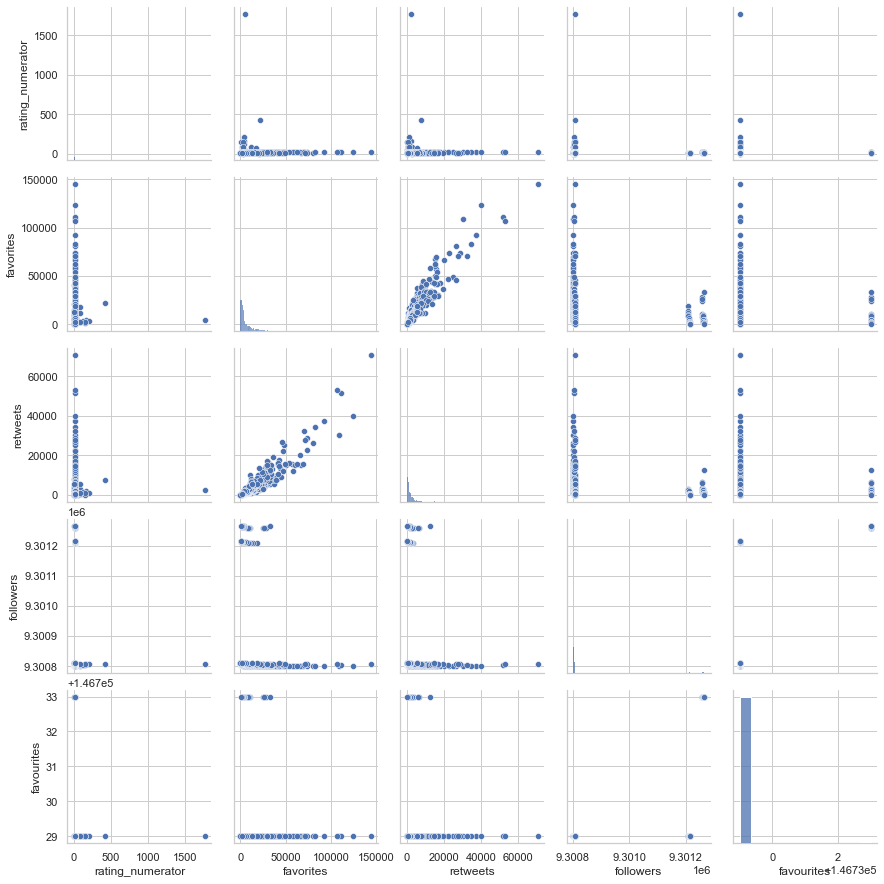

In [58]:
# Pairplot
sns.pairplot(df[['rating_numerator',
                 'favorites',
                 'retweets',
                 'followers',
                 'favourites',
                ]])

<AxesSubplot:>

Text(0.5, 1.0, 'Correlation Heat Map')

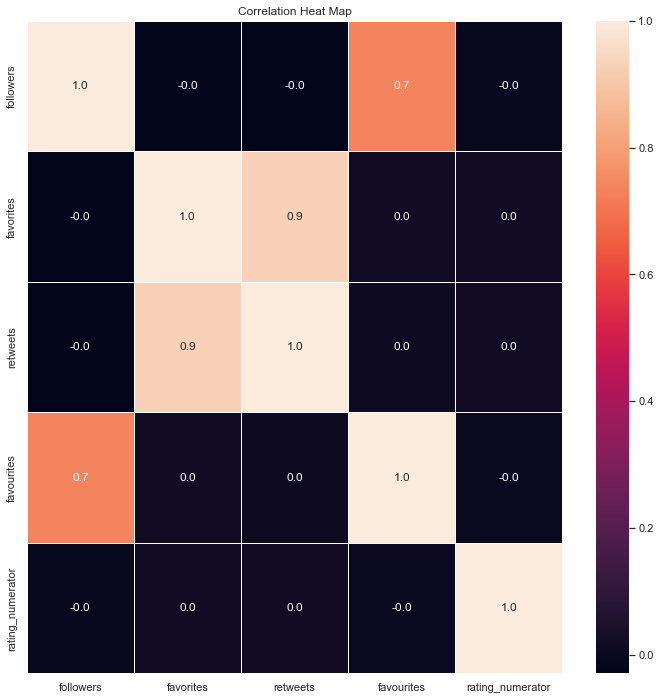

In [59]:
# Correlation map
f,ax = plt.subplots(figsize=(12, 12))
sns.heatmap(df[['followers',
                'favorites',
                'retweets',
                'favourites',
               'rating_numerator']].corr(), annot=True, linewidths=.8, fmt= '.1f',ax=ax)
plt.title('Correlation Heat Map')

### Insights:
1. There is strong correlation (0.9) between favorites and retweets. This makes sense.
1. There is correlation (0.7) between favourites and retweets. This makes sense as well.
1. There are no other correlation between the other variables. This suprises me.

### NLP for *Insights*

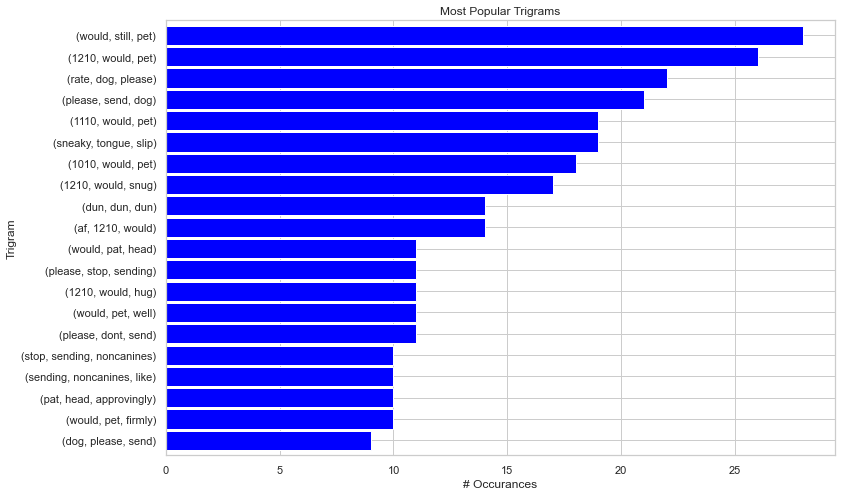

In [60]:
viz_trigrams(df, 'text', 'Most Popular Trigrams')

### Insights:
1. The text needs more cleaning.
1. The words "would still pet" is popular.
1. The significance of "1210" and "1110" needs investigation.

# Resources Used

- https://github.com/ecdedios/code-snippets/blob/main/notebooks/master.ipynb
- https://www.nltk.org/
- https://spacy.io/
- https://dkhundley.medium.com/data-science-quick-tips-001-reversing-one-hot-encoding-b0c9a892356b
- https://video.udacity-data.com/topher/2018/November/5be5fb4c_twitter-api/twitter-api.py
- https://developer.twitter.com/en/docs/platform-overview
- https://docs.tweepy.org/en/stable/getting_started.html